# Quantum kernels as partial fourier series

#### [Sashwat Anagolum](https://github.com/SashwatAnagolum)
Mentored by [**Yunong Shi**](https://godott.github.io/) as part of the QOSF mentorship program, spring '21

### Required imports

In [1]:
import numpy as np
from scipy import linalg

from functools import reduce

import pennylane as qml

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D

## Introduction

This was developed as a (tiny) part of the research that Yunong Shi and I worked on over the course of the last two and a half months, and continue to work on, as a part of the QOSF mentorship program. In this notebook, following the results from \[[1]\], I demonstrate that quantum kernel methods can be represented as partial fourier series, and use this to construct classical approximations of quantum kernels.

### Work in progress

I am currently working on including functionality for evolutions generated by data-dependent arbitrary n-qubit Hermitians - the notebook currently only supports data encoding blocks made up of Pauli rotation gates. Additionally, provisions that allow for projected quantum kernels \[[2]\] are also in the works.

## Variational Quantum Circuits

Parametrized variational quantum circuits can be represented using a function $f_{\theta}(x)$, with data inputs $x$ and circuit parameters $\theta$. Physically, circuits are constructed by composing a series of one and two-qubit quantum gates applied to one or more logical qubits.

For example, this circuit is constructed by putting together a layer of rotation gates about the Y axis ($R_Y$ gates), and a couple of controlled-NOTs ($CX$ gates):

[1]: https://arxiv.org/abs/2008.08605
[2]: https://arxiv.org/abs/2011.01938

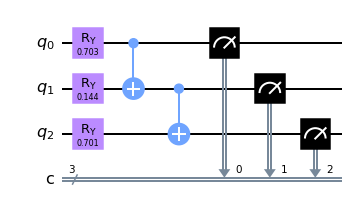

In [2]:
device = qml.device('qiskit.aer', wires=3)
weights = np.random.sample(3)

@qml.qnode(device)
def simple_circuit():
    qml.RY(weights[0], wires=0)
    qml.RY(weights[1], wires=1)
    qml.RY(weights[2], wires=2)
    
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])
    
    return qml.expval(qml.PauliZ(0))

simple_circuit()
device._circuit.draw(output='mpl')

The function $f_{\theta}(x)$, if constructed as a mapping $f: \mathbb{R}^d \rightarrow \mathbb{C}^{2^n}$ from a data vector $x = (x_1, x_2, \cdots x_{d})$ to a quantum state $|\psi\rangle$, takes the form

$$\large f_{\theta}(x) = U_{\theta}(x)\: | 0 \cdots 0 \rangle$$

where $U_{\theta}(x)$ can be further decomposed into multiple quantum gates, with some depending on variational parameters $\theta$, and some on data inputs $x$.

If we assume certain constraints on the form of the unitary $U_{\theta}(x)$, we can represent $f_{\theta}(x)$ as a vector-valued partial fourier series in the data $x$. Specifically, we require that

$$\large U_{\theta}(x) = W^{(0)}(\theta) \: S(x) \: W^{(1)}(\theta) \: S(x) \: W^{(2)}(\theta) \cdots S(x) \: W^{(L)}(\theta)$$

where $W^{(i)}(\theta)$ is an arbitrary unitary, $\S(x)$ is a data encoding block composed of gates of the form 

$$\large G(x) = e^{-i x H}$$

and $L$ is the number of times we 'reupload' the data using the encoding block $S(x)$. Given these constraints, \[[1]\] shows that each element $[f_{\theta}(x)]_{i}$ of the resulting statevector is equivalent to the partial fourier series

$$\large [f_{\theta}(x)]_i = \sum_{\omega \: \in \: \Omega} \sum_{j \in [d]} c_{\omega, j}^{(i)} (\theta) e^{i \omega x}$$

Where $\Omega$ is the set of frequencies accessible to the model, and $c_{\omega, j}^{(i)}$ are complex-valued weights determining the contribution of each frequency to the model function. A full derivation can be found in \[[1]\]. The coefficients $c_{\omega, j}^{(i)}$ are determined solely by the arbitrary unitaries $W^{(i)}(\theta)$:

$$c_{\omega, j}^{(i)} = \sum $$

**Some more intro stuff**

[1]: https://arxiv.org/abs/2008.08605
[2]: https://arxiv.org/abs/2106.03747
[3]: https://arxiv.org/abs/2011.01938
[4]: https://arxiv.org/abs/2101.11020

### Circuit layers

These functions define the different layers we can use in the circuits we construct our kernels from:

In [3]:
def ry_layer(_, params):
    """
    RY layer: Append a layer of RY gates to the quantum circuit.
    """
    for i, theta in enumerate(params):
        qml.RY(-1 * theta, wires=i)
    

def rx_layer(_, params):
    """
    RX layer: Append a layer of RX gates to the quantum circuit.
    """
    for i, theta in enumerate(params):
        qml.RX(theta, wires=i)  
        

def rz_layer(_, params):
    """
    RZ layer: Append a layer of RZ gates gates to the quantum circuit.
    """
    for i, theta in enumerate(params):
        qml.RZ(theta, wires=i) 
        

def cr_layer(gate, cr_map, num_qubits, params):
    """
    Controlled rotation layer: Append a layer of controlled pauli rotation gates to the quantum circuit.
    """
    gate = {'crz': qml.CRZ, 'cry': qml.CRY, 'crx': qml.CRX}[gate]

    if cr_map == 'linear':
        for i, theta in enumerate(params):
            gate(theta, wires=[i, i + 1])
    elif cr_map == 'full':
        for i in range(num_qubits - 1):
            offset = sum(range(num_qubits - i, num_qubits))
            for j in range(num_qubits - i - 1):
                gate(params[offset + j], wires=[i, i + j + 1])


def hadamard_layer(num_qubits, _):
    """
    Hadamard layer: Append a layer of hadamard gates to the quantum circuit.
    """
    for i in range(num_qubits):
        qml.Hadamard(wires=i)
        

def c_layer(gate, c_map, num_qubits, _):
    """
    Controlled layer: Append a layer of controlled pauli gates to the quantum circuit.
    """
    gate = {'cz': qml.CZ, 'cy': qml.CY, 'cx': qml.CNOT}[gate]
    
    if c_map == 'full':
        for i in range(num_qubits - 1):
            for j in range(num_qubits - i - 1):
                gate(wires=[i, i + j + 1])        
    else:
        for i in range(num_qubits - 1):
            gate(wires=[i, i + 1])

        if c_map == 'circular':
            gate(wires=[num_qubits - 1, 0])        
            

def eih_layer(gate, params):
    """
    eiH layer: Append a layer of rotation gates generated by arbitrary Hamiltonians to the quantum circuit.
    """
    for i, theta in enumerate(params):
        eih = linalg.expm(-1j * theta * gate)
        qml.QubitUnitary(eih, wires=i)

### Create quantum circuits

In [4]:
def qc_generator(num_qubits, layers, layer_extra_params, weights_bounds, inputs_bounds, ret_type, 
                        state_in, input_transform):
    """
    Quantum circuit generator: Generate a variational quantum circuit that accepts data inputs and variational 
    parameters based on the selected combination of layers and return type.
    """
    device = qml.device('default.qubit', wires=num_qubits)
    
    @qml.qnode(device)
    def qc(inputs, weights):                
        if state_in:
            qml.QubitStateVector(inputs[1], wires=range(num_qubits))
        
            inputs = inputs[0]
        else:
            inputs = input_transform(inputs)
        
        for i, layer in enumerate(layers):
            data_in = np.concatenate((weights[weights_bounds[i]: weights_bounds[i + 1]],
                                      inputs[inputs_bounds[i]: inputs_bounds[i + 1]]))

            layer(*layer_extra_params[i], data_in)     
        
        if ret_type == 'exp': 
            return [qml.expval(qml.PauliZ(wires=i)) for i in range(2)]
        elif ret_type == 'state':
            return qml.state()
        elif isinstance(ret_type, list) or isinstance(ret_type, tuple):
            return qml.density_matrix(wires=ret_type)
        elif ret_type == 'exp1':
            return qml.expval(qml.PauliZ(wires=0))
    
    return qc

### Utilities

In [85]:
def get_circuit_unitary(layers, layer_params, weights, weight_boundaries, inputs, input_boundaries, num_qubits):
    """
    Get circuit unitary: Get thematrx reresentation of the circuit constructed by composing layers layers, with input 
    parameters weights and inputs.
    """
    basis_states = np.eye(2 ** num_qubits)
    circ = qc_generator(num_qubits, layers, layer_params, weight_boundaries, input_boundaries, 
                               'state', True, None)
    unitary = np.stack([circ([inputs, state], weights) for state in basis_states])
    
    return unitary


def get_hamiltonian(layer, layer_extra_params):
    """
    Get Hamiltonian: Get the Hamiltonian used to construct the rotation gates for a layer.
    """
    pauli_x = np.array([[0, 1], [1, 0]])
    pauli_y = np.array([[0, 0-1j], [0+1j, 0]])
    pauli_z = np.array([[1, 0], [0, -1]])
    
    if layer == rx_layer:
        h =  pauli_x
    elif layer == ry_layer:
        h = pauli_y
    elif layer == rz_layer:
        h = pauli_z
    else:
        h = layer_extra_params[0]
        
    return h


def print_coeffs(coeffs):
    """
    Print coefficients: print out a human-friendly version of the frequencies and coefficients passed in.
    """
    freq_combos = [list(freq_combo) for freq_combo in coeffs.keys()]
    weights = list(coeffs.values())
    data_dim = len(freq_combos[0]) // 2
    string = ''
    
    for freq_combo, weight in zip(freq_combos, weights):
        eigs_x_1 = ' + '.join(['{} * x_{}'.format(freq, i) for i, freq in enumerate(freq_combo[:data_dim])])
        eigs_x_2 = ' + '.join(['{} * x\'_{}'.format(freq, i) for i, freq in enumerate(freq_combo[data_dim:])])
        if weight.real > 1e-6:
            string += '{:.6f} * exp(i * {}) +\n'.format(weight.real, eigs_x_1 + ' + ' + eigs_x_2)
        
    print(string[:-3])

### Circuit frequency computation

In [6]:
def diagonalize_layers(layers, layer_extra_params, num_qubits):
    vs = []
    diag_Hs = []
    
    for i, layer in enumerate(layers):
        hamiltonian = get_hamiltonian(layer, layer_extra_params[i])
        vals, vects = np.linalg.eig(hamiltonian)
        
        v = vects
        
        for i in range(num_qubits - 1):
            v = np.kron(v, vects)

        vs.append(v)
        diag_H = np.zeros((2 ** num_qubits, 2 ** num_qubits)).astype('complex128')
        
        for j in range(num_qubits):
            ops = [np.eye(2) for i in range(j)] + [np.diag(vals)] + [np.eye(2) for i in range(j + 1, num_qubits)]
            diag_H += reduce(lambda a, b: np.kron(a, b), ops)
            
        diag_Hs.append(0.5 * np.diag(diag_H))

    return diag_Hs, vs

            
def compute_state_freqs(eig_vals, num_qubits_per_feat=1):
    """
    Compute state frequencies: computes the frequencies accessible by the quantum circuit with embedding blocks S(x) with
    diagonal representations eig_vals. Currently only with 1-qubit Pauli rotation gates, but can be easily extended 
    to include S(x) made up of n-qubit, arbitrary rotation gates.
    """
    num_embeddings = len(eig_vals)
    num_qubits = int(np.log2(len(eig_vals[0])))
    num_feats = num_qubits // num_qubits_per_feat
    kernel_freqs = []
    pauli_eigs = [0.5, -0.5]  
    
    for i in range((2 ** num_qubits) ** num_embeddings):
        i_b = []
        sub_i_bs = []
        current_num = i
        
        for j in range(num_embeddings):
            i_b.append(current_num // ((2 ** num_qubits) ** (num_embeddings - j - 1)))
            current_num %= ((2 ** num_qubits) ** (num_embeddings - j - 1))
            
        for j in i_b:
            sub_i_b = []
            current_num = j
            
            for k in range(num_feats):
                sub_i_b.append(current_num // (2 ** (num_feats - k - 1)))
                current_num %= (2 ** (num_feats - k - 1))
                
            sub_i_bs.append(sub_i_b)
        
        if num_qubits_per_feat == 1:
            kernel_freqs.append([sum([pauli_eigs[sub_i_bs[j][i]] 
                                            for j in range(num_embeddings)]) for i in range(num_feats)])

    return [tuple(freqs) for freqs in kernel_freqs]

### Circuit coefficient computation

In [7]:
def get_embedding_layers(layers, input_bounds):
    indices = []
    embedding_layers = []
    
    for i, layer in enumerate(layers):
        if input_bounds[i + 1] - input_bounds[i]:
            embedding_layers.append(layer)
            indices.append(i)
            
    return embedding_layers, indices


def get_unitaries(layers, layer_params, weights, weight_bounds, input_bounds, num_qubits):
    init_unitaries = []
    indices = []
    trimmed_indices = []
    inputs = [0 for i in range(input_bounds[-1])]
    i = 0
    
    for i, layer in enumerate(layers):
        if input_bounds[i] == input_bounds[i + 1]:
            indices.append(i)
            
    last_break = indices[0]
    
    for i in range(1, len(indices)):
        if indices[i] - indices[i - 1] > 1:
            trimmed_indices.append([last_break, indices[i - 1] + 1])
            last_break = indices[i]
            
    trimmed_indices.append([last_break, indices[-1] + 1])
            
    for i in range(len(trimmed_indices)):
        unitary_layers = layers[trimmed_indices[i][0]: trimmed_indices[i][1]]
        unitary_layer_params = layer_params[trimmed_indices[i][0]: trimmed_indices[i][1]]
        unitary_weight_bounds = weight_bounds[trimmed_indices[i][0]:trimmed_indices[i][1] + 1]
        unitary_input_bounds = input_bounds[trimmed_indices[i][0]:trimmed_indices[i][1] + 1]
        init_unitaries.append(get_circuit_unitary(unitary_layers, unitary_layer_params, weights, 
                                                  unitary_weight_bounds, inputs, unitary_input_bounds, 
                                                  num_qubits))
        
    return init_unitaries, trimmed_indices


def update_unitaries(init_unitaries, v_daggers, unitary_indices):
    if not len(v_daggers):
        return init_unitaries
    
    init_unitaries = [init_unitary for init_unitary in init_unitaries]
    updated_unitaries = [] 
    if unitary_indices[0][0]:
        init_unitaries.insert(0, np.eye(init_unitaries[0].shape[0]))
        
    updated_unitaries.append(np.matmul(init_unitaries[0], v_daggers[0]))
    
    for i in range(1, len(init_unitaries) - 1):
        updated_unitaries.append(np.matmul(np.conj(v_daggers[i - 1].T), np.matmul(init_unitaries[i], v_daggers[i])))
    
    updated_unitaries.append(np.matmul(np.conj(v_daggers[-1].T), init_unitaries[len(v_daggers)]))
    
    return updated_unitaries


def compute_state_coeffs(unitaries, eig_vals, state_freqs, num_feats):
    coeffs = [{freq:0 for freq in list(set(state_freqs))} for i in range(eig_vals[0].shape[0])]
    num_embeddings = len(eig_vals)
    freqs = []
    
    for i in range(eig_vals[0].shape[0]):
        for j in range((2 ** num_qubits) ** num_embeddings):
            j_b = [0]
            current_num = j
            
            for k in range(num_embeddings):
                j_b.append(current_num // ((2 ** num_qubits) ** (num_embeddings - k - 1)))
                current_num %= ((2 ** num_qubits) ** (num_embeddings - k - 1))
             
            j_b.append(i)
            freq_combo = state_freqs[j]
            prod = 1
            for idx, unitary in enumerate(unitaries):
                prod *= unitary[j_b[idx], j_b[idx + 1]]

            coeffs[i][freq_combo] += prod

    return coeffs

### Create quantum states from collections of frequencies and coefficients

In [8]:
def get_state_from_coeffs(inputs, coeffs):
    state = np.zeros(len(coeffs)).astype('complex128')
    
    for i in range(len(coeffs)):
        for freq_combo, weight in coeffs[i].items():
            state[i] += weight * np.exp(-1j * sum([freq * inputs[idx] for idx, freq in enumerate(list(freq_combo))]))
    
    return state

### Get simplified coefficients

In [11]:
def simplify_coeffs(coeffs):
    num_feats = len(list(coeffs[0].keys())[0])
    simple_coeffs = [[{freq:0 for freq in set([combo[j] for combo in coeffs[i].keys()])} 
                      for j in range(num_feats)] for i in range(len(coeffs))]
    
    for i in range(len(coeffs)):
        for freq_combo in coeffs[i].keys():
            for feat in range(num_feats):
                 simple_coeffs[i][feat][freq_combo[feat]] += coeffs[i][freq_combo]
    
    return simple_coeffs

### Convert state coefficients to kernel coefficients

In [45]:
def compute_kernel_coeffs(coeffs):
    kernel_coeffs = dict()
    
    for i, idx_coeffs in enumerate(coeffs):
        for freq_combo, weight in idx_coeffs.items():
            for freq_combo_2, weight_2 in idx_coeffs.items():
                key = tuple([-freq for freq in freq_combo] + [freq for freq in freq_combo_2])
                if key not in kernel_coeffs.keys():
                    kernel_coeffs[key] = 0
                    
                kernel_coeffs[key] += np.conj(weight) * weight_2
                
    return kernel_coeffs

### Get kernel function from coefficients

In [46]:
def get_kernel_from_coeffs(inputs_1, inputs_2, coeffs):
    res = 0
    
    for freq_combo, coeff in kernel_coeffs.items():
        prod = np.dot(np.concatenate((inputs_1, inputs_2)), [freq for freq in freq_combo])
        res += coeff * np.exp(1j * prod)
        
    return res

### Testing the quantum circuit to partial fourier series method

If the conversion works right, then we should get the same state by running a quantum circuit and outputting a statevector and by converting it into a $2^n$-dimensional partial fourier series and evaluating the value of the series at the data input values.

First, we run a small (or big!) quantum circuit with random weights and input values:

In [31]:
num_qubits = 2
layers = [ry_layer, rx_layer] * 2
layer_params = [[None], [None]] * 2
weight_boundaries = [0, 0, 2, 2, 4]
input_boundaries = [0, 2, 2, 4, 4]
weights = 2 * np.pi * np.random.sample(4)
inputs = [*list(2 * np.pi * np.random.sample(2))] * 2

circ = qc_generator(num_qubits, layers, layer_params, weight_boundaries, input_boundaries, 'state', False, lambda x: x)
state_qc = circ(inputs, weights)
state_qc

tensor([-0.50177375-0.18059506j,  0.58190168+0.573128j  ,
         0.04564803+0.1114433j ,  0.00803226-0.18426989j], requires_grad=True)

Now we use the same weights and inputs to figure out an equivalent partial fourier series:

In [32]:
embedding_layers, embedding_indices = get_embedding_layers(layers, input_boundaries)
diag_hs, v_daggers = diagonalize_layers(embedding_layers, layer_params, num_qubits)

init_unitaries, unitary_indices = get_unitaries(layers, layer_params, weights, weight_boundaries, 
                                                input_boundaries, num_qubits)

updated_unitaries = update_unitaries(init_unitaries, v_daggers, unitary_indices)

state_freqs = compute_state_freqs(diag_hs, 1)
coeffs = compute_state_coeffs(updated_unitaries, diag_hs, state_freqs, 2)

state_fourier = get_state_from_coeffs(inputs, coeffs)
state_fourier

array([-0.50177375-0.18059506j,  0.58190168+0.573128j  ,
        0.04564803+0.1114433j ,  0.00803226-0.18426989j])

Now we can compare the two:

In [33]:
np.mean(np.abs(state_qc - state_fourier))

tensor(3.25291453e-16, requires_grad=True)

So the two vectors are the same, meaning that the partial fourier series returned is equivalent to the quantum circuit.

### Get kernel coefficients from state coefficients

Since the circuit we use to embed and transform our data to compute the quantum kernel reamins the same for every data point, we can use the coefficients and frequencies from the partial fourier series constructed fro the quantum states created by the circuit to compute the coefficients and frequencies that the quantum kernel gives rise to.

Here we create a new variational circuit, compute the assocated frequencies and coefficients, and use those to construct the partial fourier series representation of the kernel function:

In [87]:
num_qubits = 2
layers = [ry_layer, rx_layer] * 5
layer_params = [[None], [None]] * 5
weight_boundaries = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
input_boundaries = [0, 2, 2, 4, 4, 6, 6, 8, 8, 10, 10]
weights = [0]
inputs_1 = [*list(2 * np.pi * np.random.sample(2))] * 5
inputs_2 = [*list(2 * np.pi * np.random.sample(2))] * 5

circ = qc_generator(num_qubits, layers, layer_params, weight_boundaries, input_boundaries, 'state', False, lambda x: x)
state_1 = circ(inputs_1, weights)
state_2 = circ(inputs_2, weights)

circuit_kernel_eval = np.dot(np.conj(state_1), state_2)

In [88]:
embedding_layers, embedding_indices = get_embedding_layers(layers, input_boundaries)
diag_hs, v_daggers = diagonalize_layers(embedding_layers, layer_params, num_qubits)

init_unitaries, unitary_indices = get_unitaries(layers, layer_params, weights, weight_boundaries, 
                                                input_boundaries, num_qubits)

updated_unitaries = update_unitaries(init_unitaries, v_daggers, unitary_indices)

state_freqs = compute_state_freqs(diag_hs, 1)
coeffs = compute_state_coeffs(updated_unitaries, diag_hs, state_freqs, 2)
kernel_coeffs = compute_kernel_coeffs(coeffs)

fourier_kernel_eval = get_kernel_from_coeffs(inputs_1[:2], inputs_2[:2], kernel_coeffs)

We can check whether the two outputs are the same or not:

In [89]:
np.abs(circuit_kernel_eval - fourier_kernel_eval)

1.8875797954339384e-15

Looks like they are - so the kernel frequency and coefficient computation works!

Let's look at the fourier representation of the kernel function:

In [90]:
print_coeffs(kernel_coeffs)

0.250000 * exp(i * -2.5 * x_0 + -2.5 * x_1 + 2.5 * x'_0 + 2.5 * x'_1) +
0.250000 * exp(i * 2.5 * x_0 + 2.5 * x_1 + -2.5 * x'_0 + -2.5 * x'_1) +
0.250000 * exp(i * -2.5 * x_0 + 2.5 * x_1 + 2.5 * x'_0 + -2.5 * x'_1) +
0.250000 * exp(i * 2.5 * x_0 + -2.5 * x_1 + -2.5 * x'_0 + 2.5 * x'_1)


## Conclusions

In this notebook, I presented what is, to the best of my knowledge, the first implementation of the quantum circuit $\rightarrow$ partial fourier series equivalence proven in \[[1]\]. I hope that this helps in the exploration of the properties of the states generated by variational quantum circuits (and quantum kernel methods) more easily, in particular by allowing for easy access to the coefficients of the partial fourier series of the quantum circuits we create.

[1]: https://arxiv.org/abs/2008.08605

## References

\[1\] Maria Schuld, Ryan Sweke, Johannes Jakob Meyer. The effect of data encoding on the expressive power of variational quantum machine learning models, 2020. [arXiv:2008.08605 [quant-ph]](https://arxiv.org/abs/2008.08605)

\[2\] Hsin-Yuan Huang, Michael Broughton, Masoud Mohseni, Ryan Babbush, Sergio Boixo, Hartmut Neven, Jarrod R. McClean. power of data in quantum machine learning, 2020. [arXiv:2011.01938v2 [quant-ph]](https://arxiv.org/abs/2011.01938)